In [228]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from matplotlib import cm
# import timeit
from scipy.integrate import odeint
from scipy import stats
from sklearn.manifold import MDS
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [234]:
nyears = 1

settlingTime = 2 ** 0
tlen = 2 ** 8
end = 2 ** 8# 2**5 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
# trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 3
ndrivers = 0

# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [235]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
# x0 = np.array([0.49])
#x0 = np.array([0.1,0.4,9])
# x0 = rand.random(99)
x0 = rand.random(3)

# m = 50
# x0 = np.ones(m) * (np.pi ** -1)
# x0[0] += 0.2
# x0[1] += 0.3
# x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 4 - t / tlen# + 0.5 * np.sin(np.pi * t / tlen)
# m = lambda t: 0.3
# b1 = lambda t: 5 - 1.5 * np.cos(2*np.pi*t / end)
# b1 = lambda t: 4.5 # 2.5 + 4 * t / end
# c = lambda t: 2+2*t/256+np.sin(t)
# rho = lambda t : 28 # + 10 * t / end
# sigma = lambda t : 10 # + 10 * t / end
# beta = lambda t : 8.0 / 3.0 + 4*t/end
# m = lambda t : t / end

""" GENERATE TS """
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)
# Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=tlen, end=end, reduction=reduction, settlingTime=settlingTime)
# Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime))[:,0,None]
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
Xr = generateTimeSeriesDiscrete("Tents", x0, settlingTime=0, tlen=tlen)
# Xr = generateTimeSeriesDiscrete("Tent", x0, nsargs=(m,), settlingTime=0, tlen=tlen)
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
# Xr = generateTimeSeriesDiscrete("LogisticIslandsP", x0, nsargs=(r, m), tlen=tlen, settlingTime=settlingTime)[:,4,None
# Xr = generateTimeSeriesContinuous('LorenzP', np.array([1,5,17]), nsargs=(rho, sigma, beta), tlen=tlen, end=end, settlingTime=settlingTime, reduction= reduction)[:,0,None]

In [236]:
# Add obversation noise to the data

a = 0
Xr += a * np.ptp(Xr) * rand.random(Xr.shape)

In [237]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""

"""
num = "C"
file = f"../Datasets/Becks/Figure1Plot{num}.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
Xr = standardize(data[1:52].to_numpy()[:,1:4].astype(float))
t = np.linspace(0,1,num=Xr.shape[0])
tr = t
"""
# END FROM DATA

'\nnum = "C"\nfile = f"../Datasets/Becks/Figure1Plot{num}.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nXr = standardize(data[1:52].to_numpy()[:,1:4].astype(float))\nt = np.linspace(0,1,num=Xr.shape[0])\ntr = t\n'

In [238]:

""" UPDATE DRIVERS HERE """

digiDrivers = [m]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
# gtsr = b1(t) # driverArray
# gtsr = c(t)
# gtsr = beta(t)
gtsr = m(t)

<IPython.core.display.Javascript object>


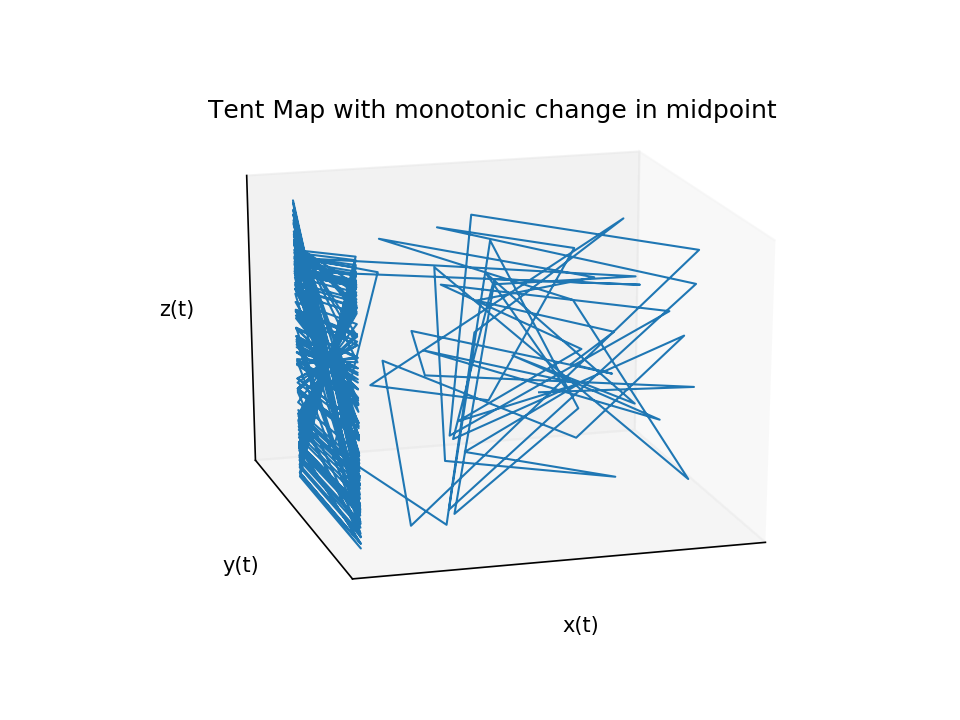

<IPython.core.display.Javascript object>


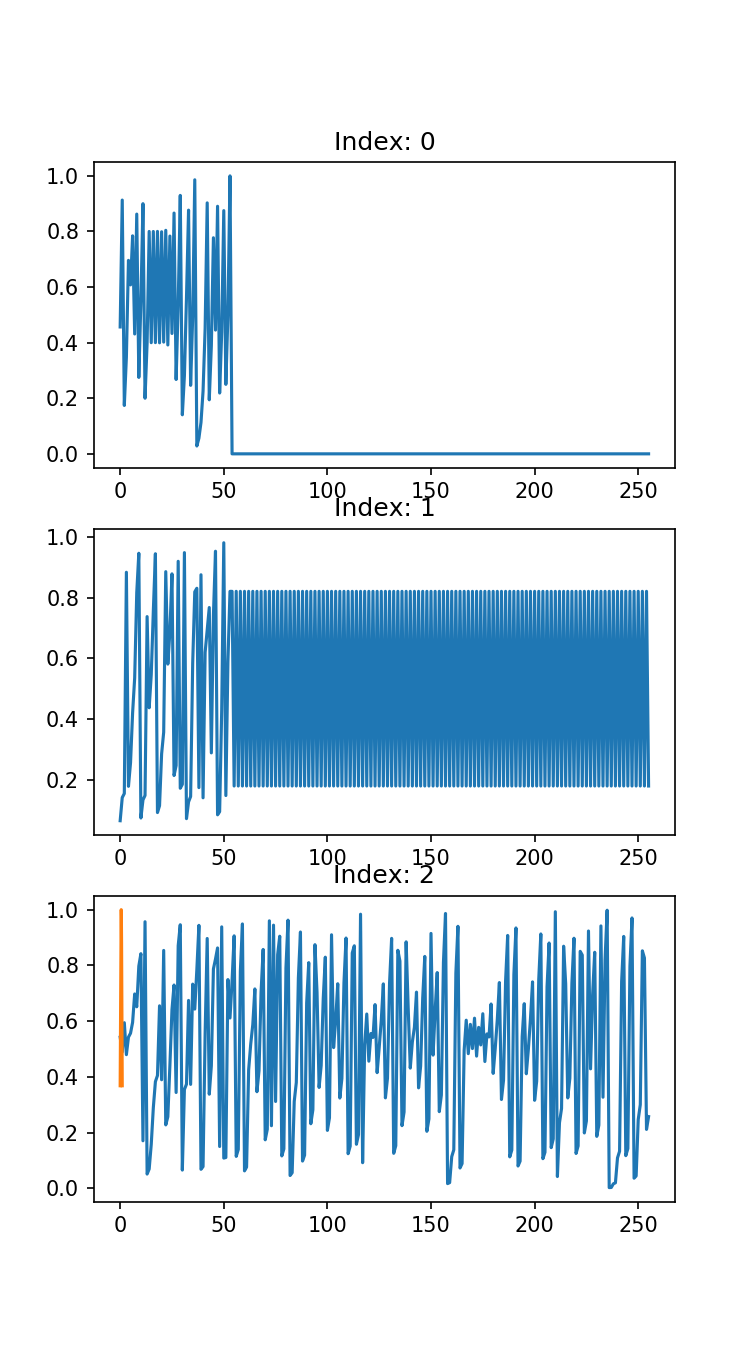

In [239]:
title = "Tent Map with monotonic change in midpoint"

fig2 = plt.figure(5)

if dim == 1:
    ax2 = fig2.add_subplot(111)
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2], linewidth=1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x(t)")
    ax2.set_ylabel("y(t)")
    ax2.set_zlabel("z(t)")
    
ax2.set_title(title)

plt.show()
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
# plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
        axD.set_xticks([])
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [174]:
"""
n = 100
similarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))
similarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8
"""

'\nn = 100\nsimilarity_matrix = np.fromfunction(lambda i,j: np.exp(-((i-j)/n)**2), (n,n))\nsimilarity_matrix = (similarity_matrix - np.mean(similarity_matrix) ) / np.var(similarity_matrix) * 8\n'

In [175]:
#embedding = MDS(dissimilarity="precomputed", n_components=10)
#X_transformed = embedding.fit_transform(similarity_matrix)

In [176]:
#fig, ax = plt.subplots(1)
#ax.plot(X_transformed[:,0])
#plt.show()

In [177]:
# transformed = MDStimescaleDecomp(Xr)

<IPython.core.display.Javascript object>


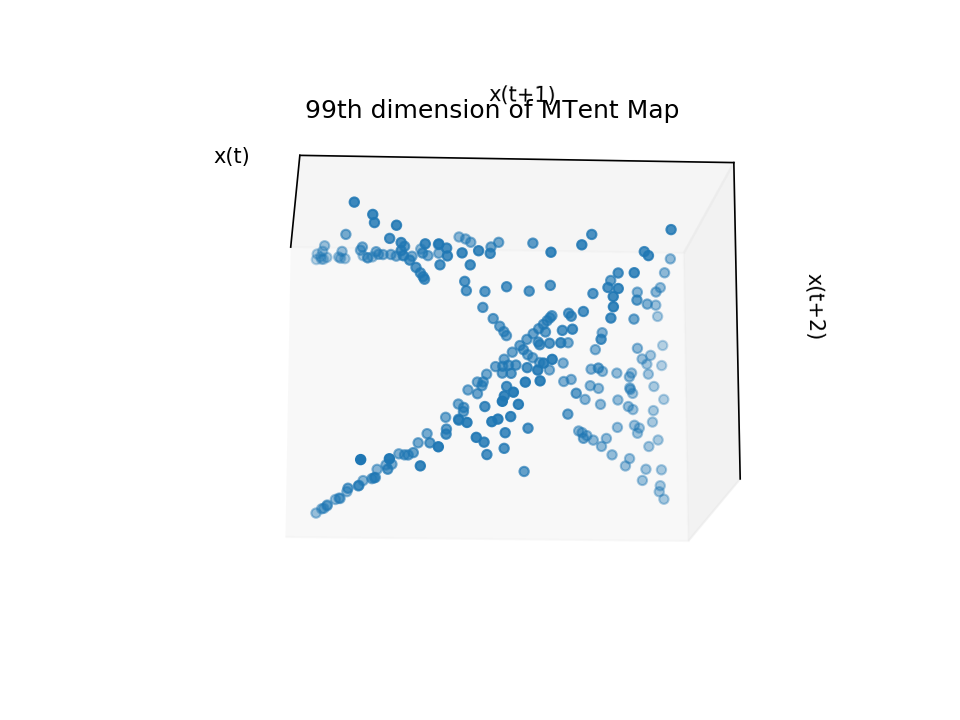

In [178]:
poincare3d(Xr, title=title, step=1)

<IPython.core.display.Javascript object>


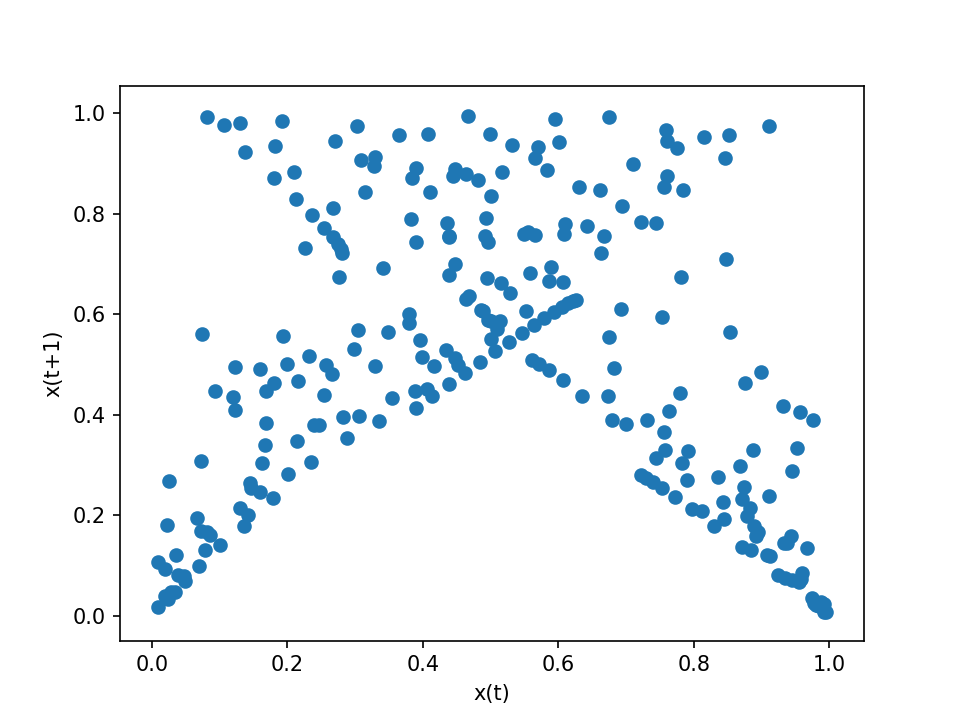

In [180]:
poincare2d(Xr, step = 1)

<IPython.core.display.Javascript object>


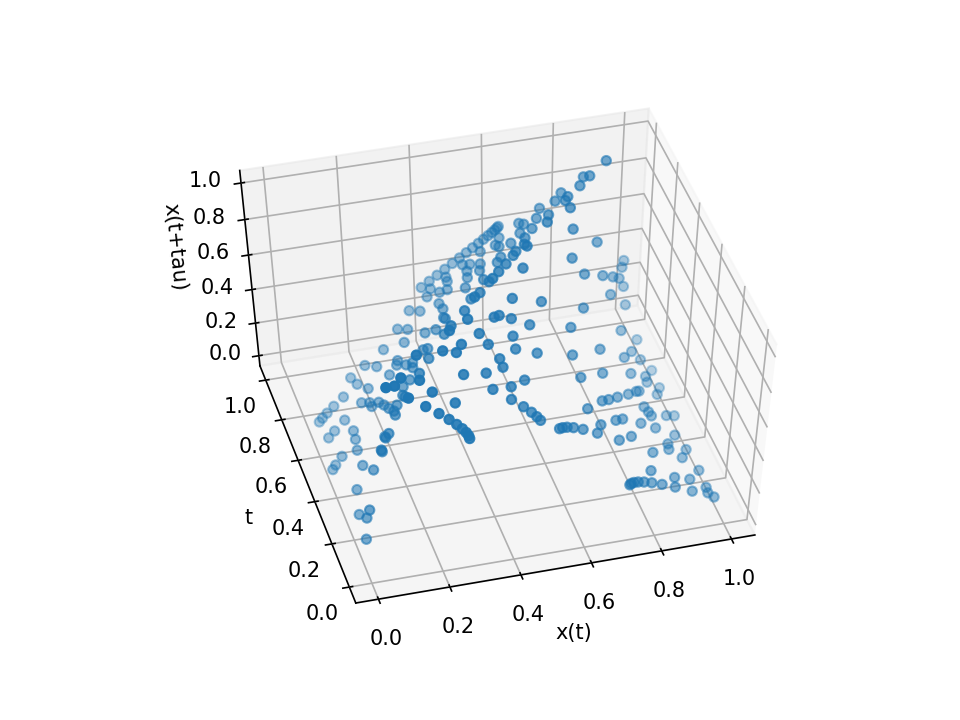

In [186]:
poincareT(Xr, step=1)

In [144]:
# FNNplot(Xr, 5, 4)

In [160]:
horizon = 1
maxLags = 6

In [146]:
# thetaNS, deltaNS, llikelihoodNS, lagsNS, tauNS, thetaS, llikelihoodS, lagsS, tauS = optimizationSuite(Xr, tr, predictionHorizon, lagRange, tauRange, errFunc=logUnLikelihood)
thetaNS, deltaNS, errNS, lagsNS, tauNS, thetaS, errS, lagsS, tauS = optimizationSuite(Xr, t, horizon, maxLags, errFunc=logUnLikelihood)

(253,) (253,)
E = 2, tau = 1
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -42.522
[02] theta: 1.100, delta: 0.000, log Likelihood: 19.703
[03] theta: 2.310, delta: 0.000, log Likelihood: 30.233
[04] theta: 3.641, delta: 0.000, log Likelihood: 29.233
[05] theta: 2.976, delta: 0.000, log Likelihood: 30.179
[06] theta: 2.243, delta: 0.000, log Likelihood: 30.145
[07] theta: 2.609, delta: 0.000, log Likelihood: 30.380
[08] theta: 2.426, delta: 0.000, log Likelihood: 30.334
[09] theta: 2.518, delta: 0.000, log Likelihood: 30.372
[10] theta: 2.619, delta: 0.000, log Likelihood: 30.379
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -42.522
[02] theta: 1.100, delta: 0.000, log Likelihood: 19.703
[03] theta: 2.310, delta: 0.000, log Likelihood: 30.233
[04] theta: 3.641, delta: 0.000, log Likelihood: 29.233
[05] theta: 2.976, delta: 0.000, log Likelihood: 30.179
[06] theta: 2.243, delta: 0.000, log Likelihood: 30.145
[07] theta: 2.609, delta: 0.000, log Likelihood: 30.380
[08] t

In [147]:
""" COMPUTE DOFS """

Xn, Yn, txn = delayEmbed(Xr, horizon, lagsNS, tauNS, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

Xs, Ys, txs = delayEmbed(Xr, horizon, lagsS, tauS, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaS, 0)


"""
emb_array = (np.ones(Xr.shape[1])*lagsNS).astype(int)
Xn, Yn = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)
txn = np.linspace(0,1,num=Xn.shape[0])

emb_array = (np.ones(Xr.shape[1])*lagsS).astype(int)
Xs, Ys = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)
txs = np.linspace(0,1,num=Xs.shape[0])

dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)
dofS = dofestimation(Xs, Ys, txs, thetaS, 0)
"""

(254,) (254,)
(254,) (254,)


'\nemb_array = (np.ones(Xr.shape[1])*lagsNS).astype(int)\nXn, Yn = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)\ntxn = np.linspace(0,1,num=Xn.shape[0])\n\nemb_array = (np.ones(Xr.shape[1])*lagsS).astype(int)\nXs, Ys = delayEmbedM(Xr[:-predictionHorizon], Xr[predictionHorizon:,0,None], emb_array, lagStep)\ntxs = np.linspace(0,1,num=Xs.shape[0])\n\ndofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)\ndofS = dofestimation(Xs, Ys, txs, thetaS, 0)\n'

In [148]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaNS, deltaNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaS, 0)

In [149]:
MSElooNS = np.sum((predictedTSNS - Yn) ** 2 )
MSElooS = np.sum((predictedTSS - Ys) ** 2 )

In [150]:
MSElooNS

10.492431814806388

In [151]:
MSElooS

10.492431814806388

<IPython.core.display.Javascript object>


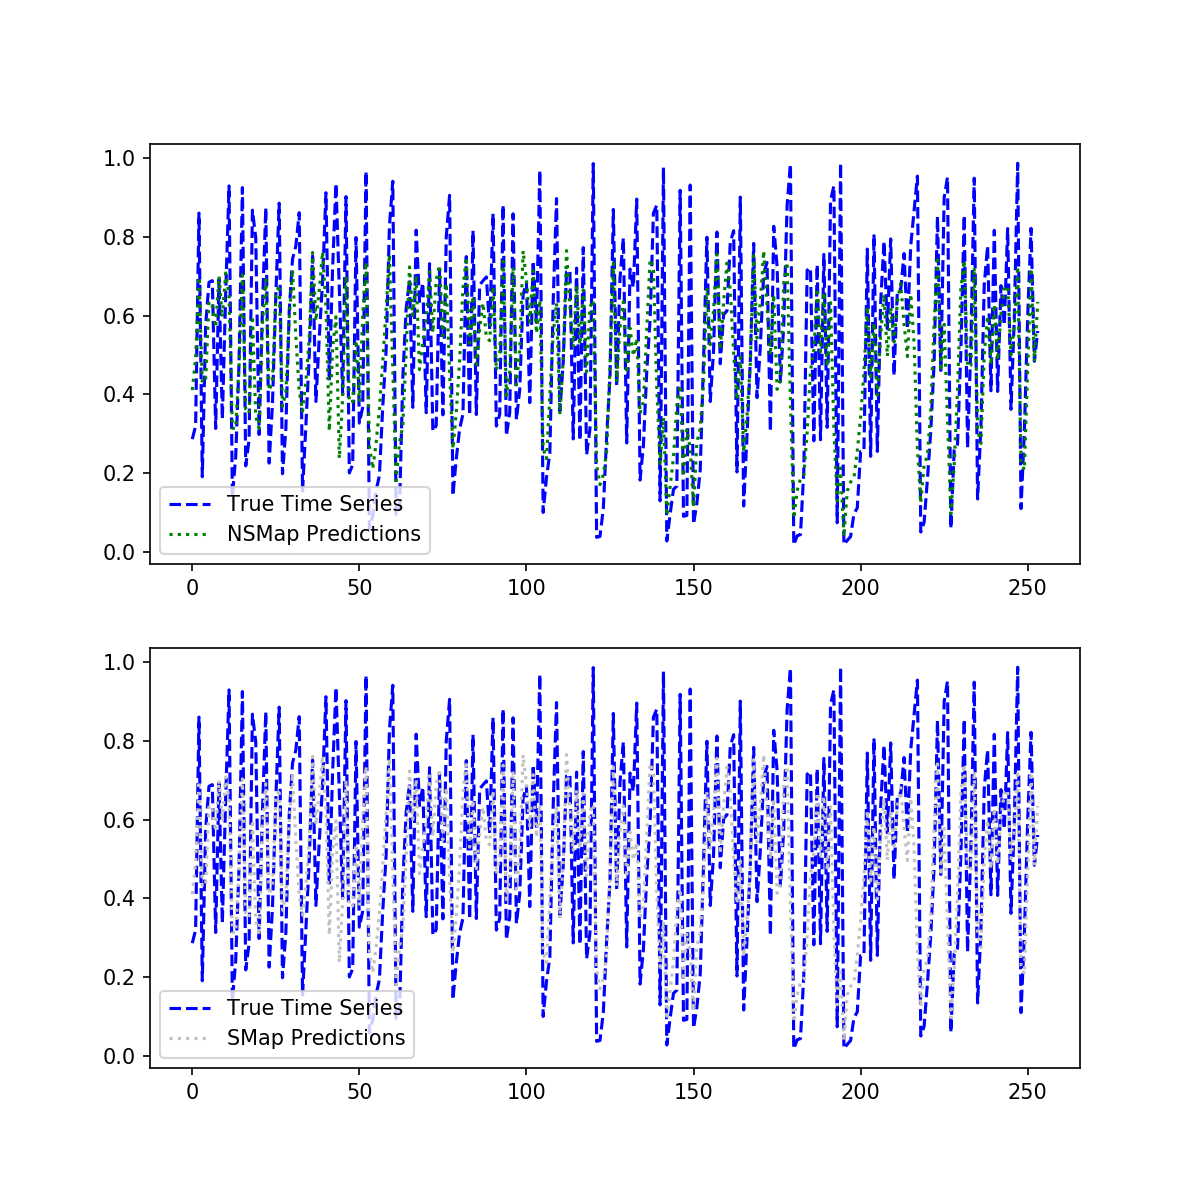

In [152]:
figLOU, axLOU = plt.subplots(2, figsize=(8,8))
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

In [153]:
AICNS = AIC(Xn, Yn, txn, thetaNS, deltaNS)
AICS = AIC(Xs, Ys, txs, thetaS, 0)

In [154]:
sequentialNS = sequential(Xn, Yn, txn, thetaNS, deltaNS,return_error=False)
sequentialS = sequential(Xs, Ys, txs, thetaS, 0,return_error=False)

YseqNS = Yn[int(Yn.shape[0]/2):]
YseqS = Ys[int(Ys.shape[0]/2):]

In [155]:
MSEseqNS = np.mean((sequentialNS-YseqNS)**2)
MSEseqS = np.mean((sequentialS-YseqS)**2)

<IPython.core.display.Javascript object>


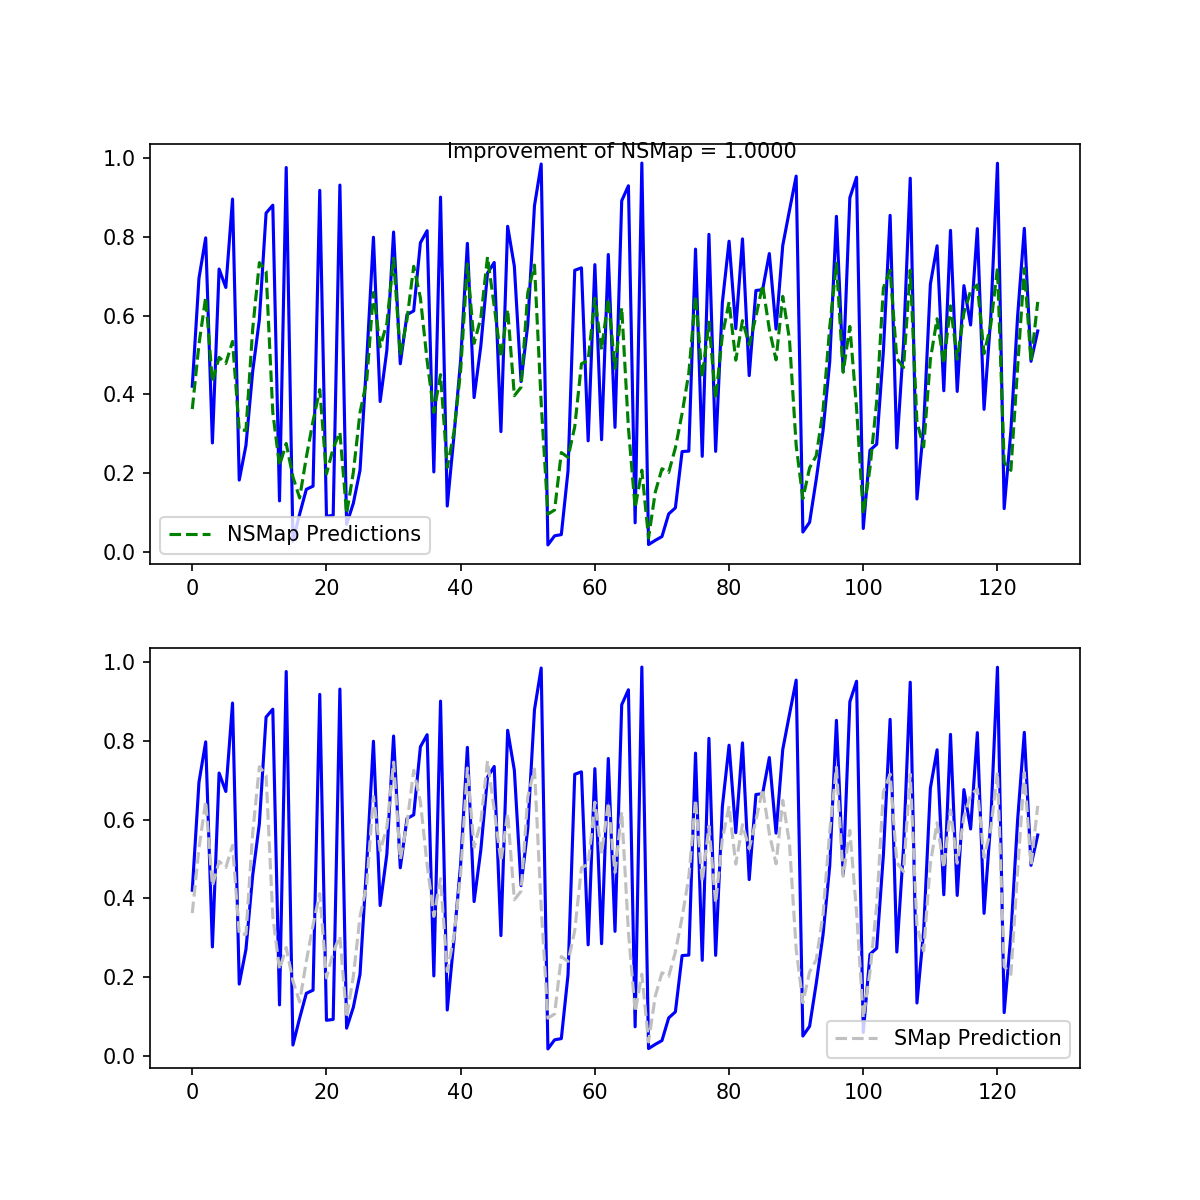

In [156]:
fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(Yn[int(Yn.shape[0]/2):], color="blue")
ax[0].plot(sequentialNS, color="green", linestyle="dashed", label="NSMap Predictions")
ax[0].text(38,1,f"Improvement of NSMap = {MSEseqS/MSEseqNS:.4f}")
ax[0].legend()

ax[1].plot(Ys[int(Ys.shape[0]/2):], color="blue")
ax[1].plot(sequentialS, color="silver", linestyle="dashed", label="SMap Prediction")
ax[1].legend()

plt.show()

In [157]:
# functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

In [158]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaNS:.3f}, delta: {deltaNS:.7f}, AIC: {AICNS:.3f}, log Likelihood: {errNS:.3f}, Optimal Embedding Dimension: {lagsNS+2}, 10% Weight Dropoff: {np.exp(-deltaNS*0.1**2)}")
print(f"SMap -- theta: {thetaS:.3f}, AIC: {AICS:.3f}, log Likelihood: {errS:.3f}, Optimal Embedding Dimension: {lagsS+2}")

print(f"Improvement of NSMap(leave one out): {MSElooS/MSElooNS:.3f}")
print(f"Improvement of NSMap(sequentially calculated): {MSEseqS/MSEseqNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(AICS, AICNS)

NSMap -- theta: 2.727, delta: 0.0000000, AIC: -12.720, log Likelihood: 30.778, Optimal Embedding Dimension: 3, 10% Weight Dropoff: 1.0
SMap -- theta: 2.727, AIC: -12.720, log Likelihood: 30.778, Optimal Embedding Dimension: 3
Improvement of NSMap(leave one out): 1.000
Improvement of NSMap(sequentially calculated): 1.000
NSMap dof: 24.858
SMap dof: 24.858
Probability NSMap beats SMap:  1.0


(249,) (249,)
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -44.636
[02] theta: 1.100, delta: 1.100, log Likelihood: 57.471
[03] theta: 2.310, delta: 2.310, log Likelihood: 110.012
[04] theta: 3.641, delta: 3.641, log Likelihood: 146.791
[05] theta: 2.976, delta: 5.105, log Likelihood: 174.602
[06] theta: 3.308, delta: 6.716, log Likelihood: 198.828
[07] theta: 3.674, delta: 8.487, log Likelihood: 218.768
[08] theta: 4.077, delta: 10.436, log Likelihood: 235.063
[09] theta: 4.520, delta: 12.579, log Likelihood: 248.226
[10] theta: 4.298, delta: 14.937, log Likelihood: 259.632
[11] theta: 4.409, delta: 17.531, log Likelihood: 269.425
[12] theta: 4.531, delta: 20.384, log Likelihood: 278.055
[13] theta: 4.665, delta: 23.523, log Likelihood: 285.748
[14] theta: 4.598, delta: 26.975, log Likelihood: 292.637
[15] theta: 4.631, delta: 30.772, log Likelihood: 298.833
[16] theta: 4.668, delta: 34.950, log Likelihood: 304.386
[17] theta: 4.709, delta: 39.545, log Likelihood: 309.325
[1

[06] theta: 4.373, delta: 0.000, log Likelihood: 85.211
[07] theta: 3.568, delta: 0.000, log Likelihood: 81.122
[08] theta: 3.970, delta: 0.000, log Likelihood: 84.242
[09] theta: 4.413, delta: 0.000, log Likelihood: 85.200
[10] theta: 4.192, delta: 0.000, log Likelihood: 85.022
[11] theta: 4.303, delta: 0.000, log Likelihood: 85.184
[12] theta: 4.424, delta: 0.000, log Likelihood: 85.194
[13] theta: 4.363, delta: 0.000, log Likelihood: 85.211
[14] theta: 4.394, delta: 0.000, log Likelihood: 85.208
DLM
[01] theta: 0.000, delta: 0.000, log Likelihood: -46.466
[02] theta: 0.000, delta: 1.100, log Likelihood: -36.524
[03] theta: 0.000, delta: 2.310, log Likelihood: -30.514
[04] theta: 0.000, delta: 3.641, log Likelihood: -27.373
[05] theta: 0.000, delta: 5.105, log Likelihood: -26.045
[06] theta: 0.000, delta: 6.716, log Likelihood: -25.798
[07] theta: 0.000, delta: 5.910, log Likelihood: -25.816
[08] theta: 0.000, delta: 6.313, log Likelihood: -25.786
[09] theta: 0.000, delta: 6.756, log

<IPython.core.display.Javascript object>


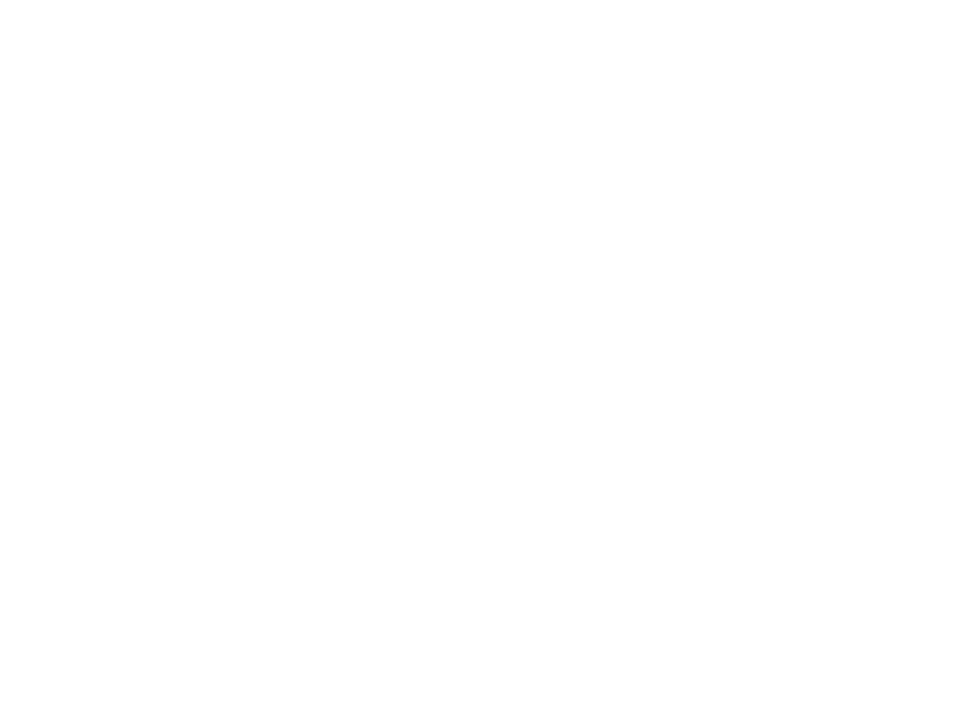

In [183]:
evslikelihood = EvsLikelihood(Xr, t, horizon, maxLags, errFunc=logUnLikelihood)

In [190]:
deltaNSandDLM = np.array([[87.005, 8.044],
          [28.978, 8.531],
          [12.168, 7.650],
          [6.608, 6.291],
          [3.271, 6.313],
          [3.094, 5.025]])

In [220]:
aggregated_delta = np.dot(deltaNSandDLM[:,0], evslikelihood[:,0] - evslikelihood[:,1]) / np.sum(evslikelihood[:,0] - evslikelihood[:,1])

In [221]:
nintyfivepercentweightdiameter = 2 * np.sqrt(-np.log(0.1)/aggregated_delta)

In [222]:
# Now we say with confidence: the window wherein points recieve 
# more than 10% weight is 0.364% of the series.

nintyfivepercentweightdiameter

0.3642880256059042

<IPython.core.display.Javascript object>


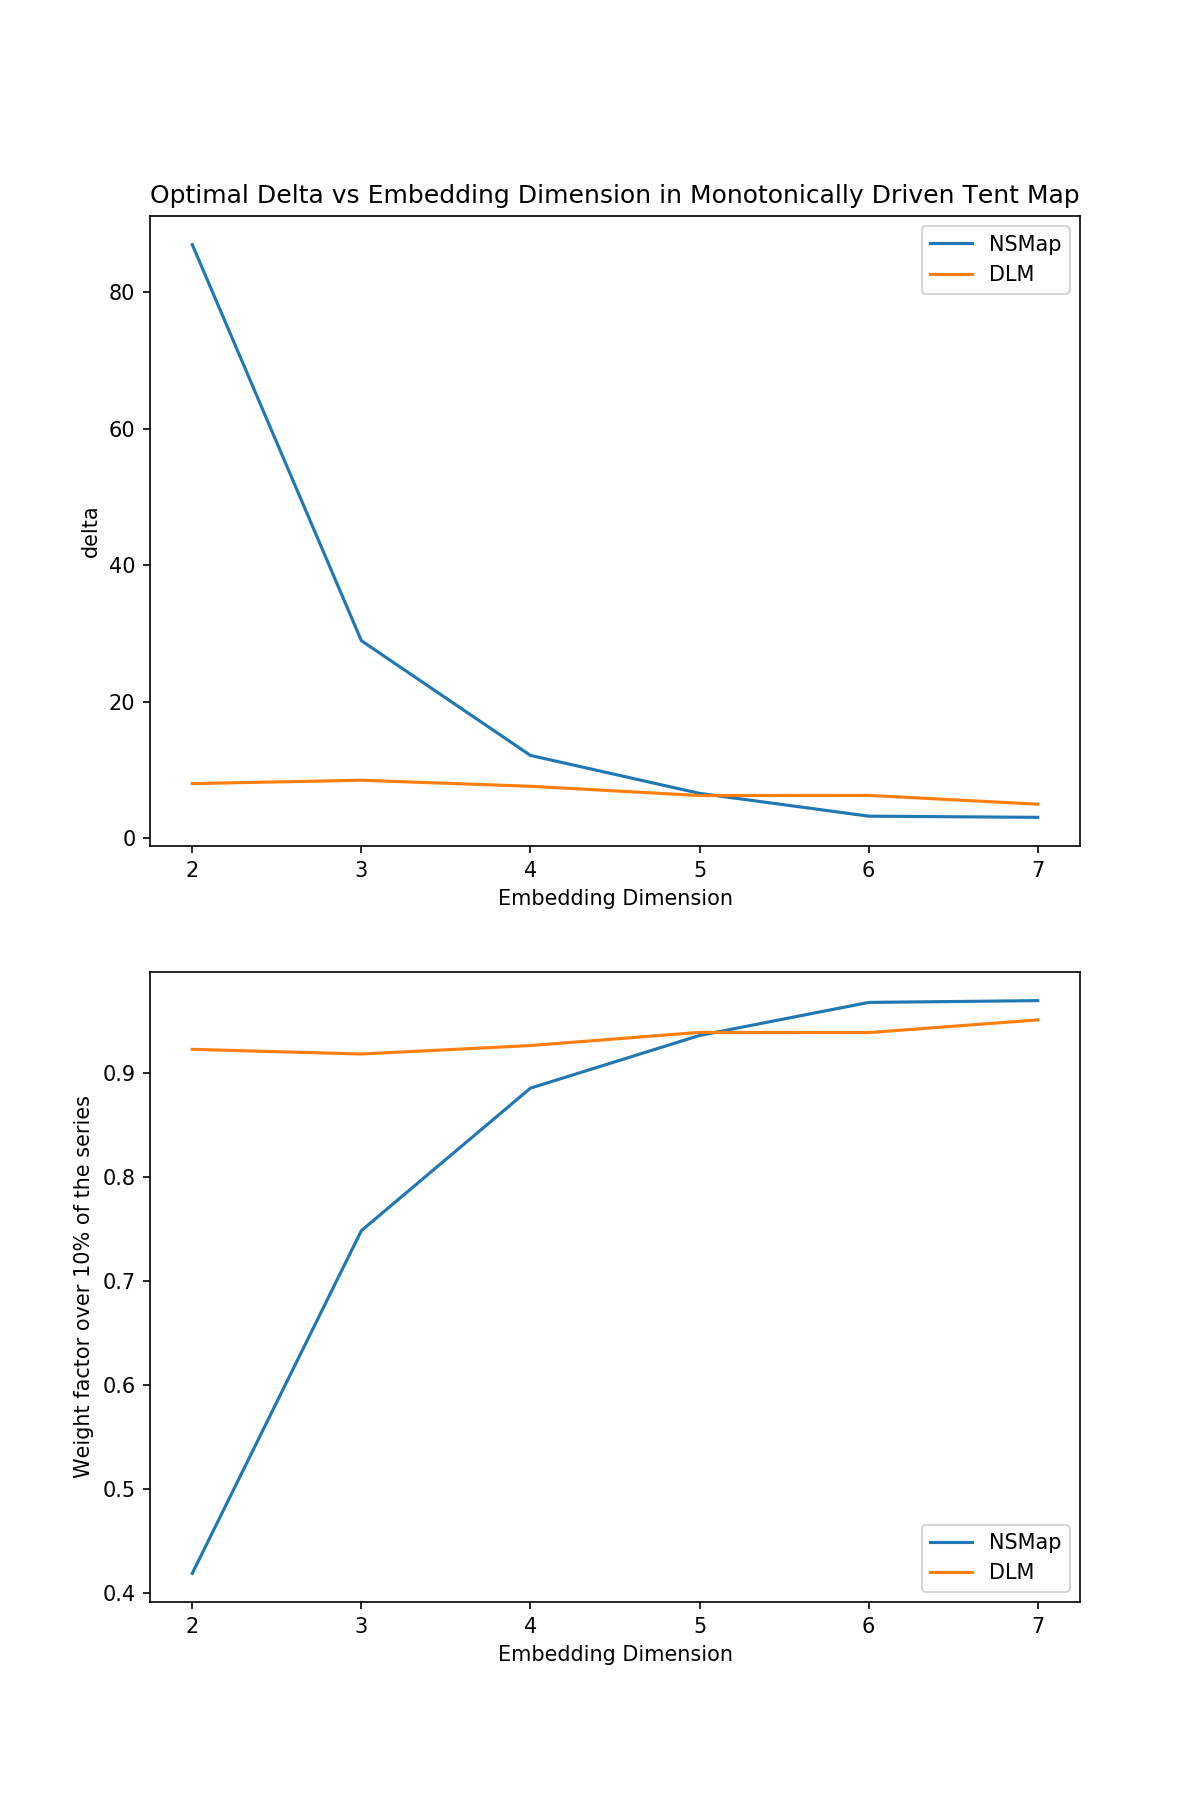

In [216]:
fix, ax = plt.subplots(2, figsize=(8,12))

ax[0].plot(np.arange(2,8), deltaNSandDLM[:,0], label="NSMap")
ax[0].plot(np.arange(2,8), deltaNSandDLM[:,1], label="DLM")
ax[0].set_xlabel("Embedding Dimension")
ax[0].set_ylabel("delta")
ax[0].legend()
ax[0].set_title("Optimal Delta vs Embedding Dimension in Monotonically Driven Tent Map")


ax[1].plot(np.arange(2,8), np.exp(-deltaNSandDLM[:,0]*(0.1**2)), label="NSMap")
ax[1].plot(np.arange(2,8), np.exp(-deltaNSandDLM[:,1]*(0.1**2)), label="DLM")
ax[1].set_xlabel("Embedding Dimension")
ax[1].set_ylabel("Weight factor over 10% of the series")
ax[1].legend()

plt.show()

<IPython.core.display.Javascript object>


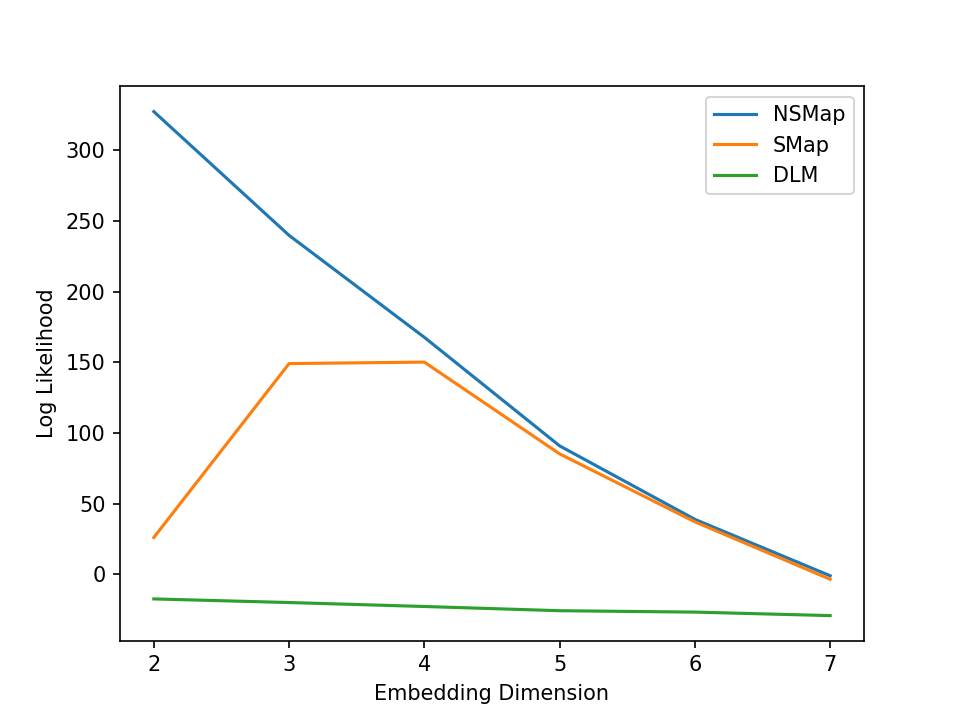

In [185]:
Es = np.array(range(2,maxLags+2))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Es, evslikelihood[:,0], label="NSMap")
ax.plot(Es, evslikelihood[:,1], label="SMap")
ax.plot(Es, evslikelihood[:,2], label="DLM")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Log Likelihood")
ax.legend()
plt.show()

In [83]:
## AREA NONSTATIONARY MEASURE ##

stationary_probability = StationaryProbability(Xr, t, 1, 10)

(245,) (245,)
NSMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -453.120
[02] theta: 0.000, delta: 1.100, log Likelihood: -441.866
[03] theta: 0.000, delta: 2.310, log Likelihood: -433.861
[04] theta: 0.000, delta: 3.641, log Likelihood: -428.425
[05] theta: 0.000, delta: 5.105, log Likelihood: -424.821
[06] theta: 0.333, delta: 6.716, log Likelihood: -421.901
[07] theta: 0.699, delta: 8.487, log Likelihood: -420.179
[08] theta: 0.516, delta: 10.436, log Likelihood: -419.218
[09] theta: 0.314, delta: 12.579, log Likelihood: -418.701
[10] theta: 0.415, delta: 14.937, log Likelihood: -418.423
[11] theta: 0.365, delta: 17.531, log Likelihood: -418.343
[12] theta: 0.309, delta: 16.234, log Likelihood: -418.316
[13] theta: 0.249, delta: 16.883, log Likelihood: -418.275
[14] theta: 0.182, delta: 17.596, log Likelihood: -418.238
[15] theta: 0.108, delta: 18.381, log Likelihood: -418.202
[16] theta: 0.027, delta: 19.244, log Likelihood: -418.168
[17] theta: 0.000, delta: 20.193, log Likel

[13] theta: 0.000, delta: 4.933, log Likelihood: -375.728
[14] theta: 0.000, delta: 5.646, log Likelihood: -375.617
[15] theta: 0.000, delta: 6.431, log Likelihood: -375.524
[16] theta: 0.000, delta: 7.294, log Likelihood: -375.431
[17] theta: 0.000, delta: 8.243, log Likelihood: -375.335
[18] theta: 0.000, delta: 9.287, log Likelihood: -375.235
[19] theta: 0.000, delta: 10.436, log Likelihood: -375.142
[20] theta: 0.000, delta: 11.700, log Likelihood: -375.066
SMap
[01] theta: 0.000, delta: 0.000, log Likelihood: -382.218
[02] theta: 1.100, delta: 0.000, log Likelihood: -385.851
[03] theta: 0.550, delta: 0.000, log Likelihood: -380.818
[04] theta: 0.000, delta: 0.000, log Likelihood: -382.218
[05] theta: 0.303, delta: 0.000, log Likelihood: -380.807
[06] theta: 0.635, delta: 0.000, log Likelihood: -381.115
[07] theta: 0.469, delta: 0.000, log Likelihood: -380.681
[08] theta: 0.286, delta: 0.000, log Likelihood: -380.847
[09] theta: 0.377, delta: 0.000, log Likelihood: -380.686
[10] th

In [184]:
stationary_probability

NameError: name 'stationary_probability' is not defined

In [252]:
np.exp(-5*(0.25)**2)

0.7316156289466418

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(2,maxLags+1), evslikelihood[:,0], label="NSMap")
ax.plot(range(2,maxLags+1), evslikelihood[:,1], label="SMap")
ax.plot(range(2,maxLags+1), evslikelihood[:,2], label="DLM")
ax.set_xlabel("Embedding Dimension")
ax.set_ylabel("Log Likelihood")
ax.legend()
plt.show()

In [42]:
dynamic_similarity_matrix = schreiberContinuous(Xn, Yn, txn, thetaNS, deltaNS)

KeyboardInterrupt: 

In [ ]:
plt.imshow(np.exp(-dynamic_similarity_matrix))

In [ ]:
driverVdelta = np.array([[0, 0.9939017526504343],
          [0.5, 0.913616621633756],
          [1, 0.9404808557939969],
          [1.5, 0.8986395799598124],
          [2.0, 0.7594675023780507],
          [2.5, 0.7385951709456133],
          [3.0, 0.7735371385558871],
          [3.5, 0.9095528584046055]])

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,3))

ax.plot(driverVdelta[:,0],driverVdelta[:,1])
ax.set_xlabel("Slope of driver")
ax.set_ylabel("Drop in weight over 10% of series length")
ax.text(1.55,0.98,f"r={np.corrcoef(driverVdelta[:,0],driverVdelta[:,1])[0,1]}")

In [ ]:
emb_diff = 1

E1, _ = delayEmbed(Xr, 1, 1, 1)
E2, _ = delayEmbed(Xr, 1, 1+emb_diff, 1)

D1 = distanceMatrix(E1)
D2 = distanceMatrix(E2)

In [ ]:
E1[1+emb_diff:]

In [ ]:
E2[1:]

In [ ]:
fig, ax = plt.subplots(3, figsize=(8,24))
ax[0].imshow(D1)
ax[1].imshow(D2)
ax[2].imshow(D1[emb_diff:,emb_diff:]-D2)

plt.show()

In [291]:
np.argsort(np.array([-8,2,6,-1]))

array([0, 3, 1, 2], dtype=int32)

In [249]:
x = np.linspace(0,1,num=500)
y = np.exp(-7 * (x-0.5)**2)

<IPython.core.display.Javascript object>


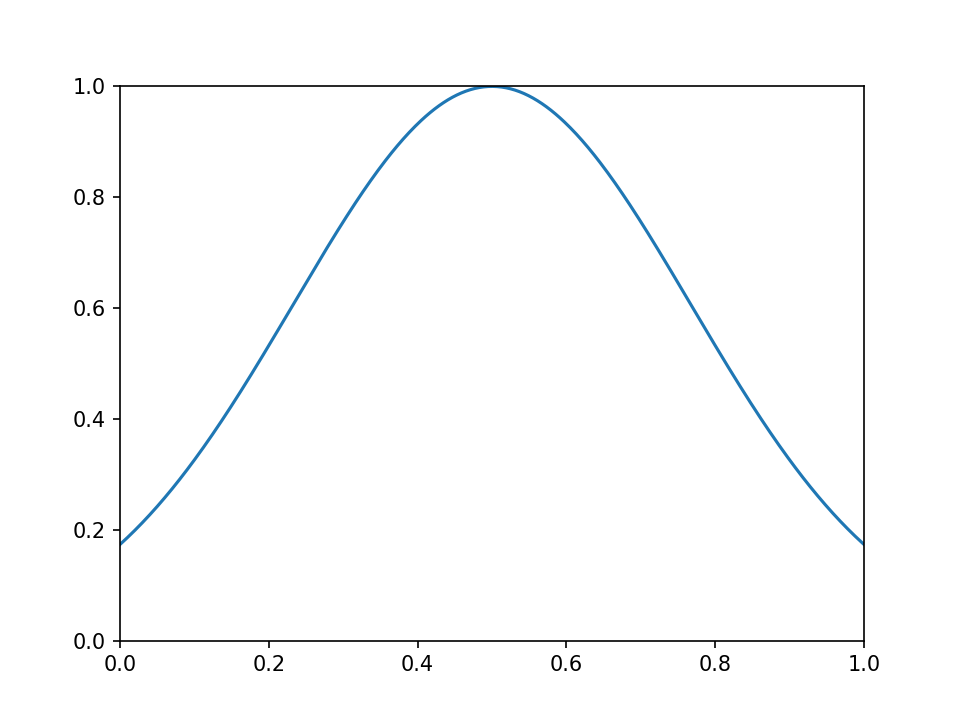

In [250]:
fig, ax = plt.subplots(1)
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot(x,y)
ax.set_title("Change in weight for delta=8 about t=0.5")
ax.set_ylabel("Factor")
ax.set_xlabel("Time")
plt.show()